# Cell Annotation using zebrafish markers

This notebook performs the cell type annotation using the translated human markers with the homology-based approach.

The PanglaoDB database works exclusively with human and mouse markers. However, to ensure that less annotated organisms are not overlooked, we have created this notebook using zebrafish markers obtained from the scientific publication "Characterization of the Zebrafisch Cell Landscape at Single-Cell Resolution". The main purpose of using the zebrafish markers was to translate them into human markers using the homology function and assess their impact on annotating the WP1 clusters.


## Loading packages

In [17]:
import markerrepo.marker_repo as mr
import markerrepo.wrappers as wrap
import markerrepo.annotation as annot
import markerrepo.parsing as pars
import markerrepo.utils as utl
import auto_annotation as auto
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import re
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/auto_annotation.py:22: RuntimeWarning: Please install the latest sctoolbox version. Some functionality may not be available.
  def get_clustering_column_list(adata):


## Settings

Specify path of the cloned repository and the h5ad file which is going to be annotated.

In [18]:
repo_path = "/mnt/workspace_stud/allstud/wp2/annotate_by_marker_and_features-sort"
h5ad_path = "/mnt/workspace_stud/allstud/wp1/data/2024_02_17/heart_lv_SM-IOBHO.h5ad"

Load anndata and list all possible settings.

In [19]:
adata = sc.read_h5ad(h5ad_path)
annot.list_possible_settings(repo_path, adata=adata)

Possible Settings:
----------------------------------------


/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1. Available columns to search in MarkerRepo:
  - List name
  - Organism name
  - Taxonomy ID
  - Marker type
  - Submitter name
  - List type
  - Date
  - Source
  - tags_transferred
  - Email
  - Tissue
  - Marker
  - Info

2. Possible organisms or taxon IDs:
  - human 9606
  - mouse 10090
  - zebrafish 7955
  - rat 10114
  - pig 9823
  - medaka 8090
  - chicken 9031
  - drosophila 7215
  - yeast 4932

3. Available columns in adata.obs:
  - n_genes_by_counts
  - log1p_n_genes_by_counts
  - total_counts
  - log1p_total_counts
  - nb_features
  - cell type
  - ontology label
  - ontology id
  - louvain_0.1
  - louvain_0.25
  - louvain_0.5
  - louvain_1
  - leiden_0.1
  - leiden_0.25
  - leiden_0.5
  - leiden_1
  - kmeans_7
  - kmeans_10
  - kmeans_13
  - kmeans_16
  - lovain_0.1
  - lovain_0.25
  - lovain_0.5
  - lovain_1

4. Available columns in adata.var:
  - louvain_0.1_gini_scores
  - louvain_0.25_gini_scores
  - louvain_0.5_gini_scores
  - louvain_1_gini_scores
  - leiden_0.1_gini

Enter general annotation settings.
(more details find at `auto_annotation_notebook.ipynb`)

In [20]:
organism = "human"
rank_genes_column = None
genes_column = None
clustering_column_list = ["leiden_0.1", "leiden_1"] # handpick example
ensembl = mr.check_ensembl(adata)
celltype_column_name = None
delete_lists = True
column_specific_terms={"Source":"panglao", "Organism name":"human"}
mr_parameters = [{"style":"two_column", "file_name":"two_column"}]

Validate general annotation settings and the mr_parameters.

In [21]:
auto.auto_validate_settings(settings=mr_parameters, repo_path=repo_path, adata=adata, organism=organism, 
                        rank_genes_column=rank_genes_column, genes_column=genes_column, clustering_column=clustering_column_list, ensembl=ensembl,
                        column_specific_terms=column_specific_terms)

All settings are valid.
Summary of settings:
----------------------------------------
General parameters:
  Repo path: /mnt/workspace_stud/allstud/wp2/annotate_by_marker_and_features-sort
  Organism: human
  Rank genes column: None
  Genes column: None
  Clustering column: ['leiden_0.1', 'leiden_1']
  Ensembl IDs: False
  Column specific terms:
    1. Column to search: Source, Search terms: panglao
    2. Column to search: Organism name, Search terms: human

Parameters from dictionary:
  1. Marker list:
    style: two_column
    file_name: two_column
----------------------------------------


True

## Create suitable marker list(s)

<details>
    <summary>Click here to see/collapse the function description</summary>
    <p><b>Function Call:</b> create_multiple_marker_lists</p>
    <p>This function calls 'create_marker_lists' with multiple parameter sets to create marker lists. It iterates over each dictionary within a list, using its contents to call 'create_marker_lists'. Default values are assigned for any parameters missing from a dictionary, but these can be overridden by individual dictionary entries.</p>
    <p><b>Parameters (excerpt):</b></p>
    <ul>
        <li><b>settings:</b> list of dict, default [{}] - A list of dictionaries where each dictionary contains parameters for a single call to 'create_marker_lists'. Keys should match the parameter names of 'create_marker_lists', and values are the desired values for those parameters.</li>
        <li><b>style:</b> str, default "score" - Determines the style of the marker lists. Available options include "two_column", "score", "ui", and "panglao".</li>
        <li><b>force_homology:</b> bool, default False - If set to True, the function will attempt to create marker lists via homology, even if marker lists for the given organism already exist.</li>
        <li><b>show_lists:</b> bool, default True - If True, the function displays the marker lists of the query post-creation.</li>
        <li><b>column_specific_terms:</b> dict, default None - A dictionary with column names as keys and lists of search terms as values. If provided, this overrides the 'col_to_search' and 'search_terms' parameters.</li>
        <li><b>adata:</b> AnnData, default None - If provided, the function adds the marker list IDs to the .uns table of the AnnData object.</li>
    </ul>
    <p><b>Returns:</b></p>
    <ul>
        <li><b>list of str:</b> A list of all paths to the created marker lists.</li>
    </ul>
</details>


The paths of the marker lists will be stored in the <b>marker_lists</b> variable. They will work as input for the actual cell type annotation of the next cell.

In [22]:
marker_lists = wrap.create_multiple_marker_lists(settings=mr_parameters, repo_path=repo_path, organism=organism, 
                                                 ensembl=ensembl, column_specific_terms=column_specific_terms,
                                                 show_lists=True, adata=adata)

Found 85 marker lists for the given organism human.


,List name,Organism name,Taxonomy ID,Marker type,Submitter name,List type,Date,Source,tags_transferred,Email,Tissue,Marker,Info
ID,,,,,,,,,,,,,
1688745545837,HCM_human_fetus,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,bio-bigdata.hrbmu.edu.cn/CellMarker,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,fetus,"[CD4, ENSG00000010610, CD163, ENSG00000177575,...","[Immune cell, Pan-endothelial cell, Myeloid ce..."
168874554211252,Panglao_human_skin,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,skin,"[FCGR2A, ENSG00000143226, EXO1, ENSG0000017437...","[Melanocytes, Keratinocytes, Langerhans cells,..."
168874554264756,Panglao_human_lungs,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,lung,"[EMP2, ENSG00000213853, SCGB3A2, ENSG000001642...","[Ciliated cells, Pulmonary alveolar type I cel..."
168874554292179,Panglao_human_na,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,na,"[PHOX2B, ENSG00000109132, MCOLN3, ENSG00000055...","[Pluripotent stem cells, T cells naive, Taste ..."
168874554338416,HCM_human_adipose-tissue,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,bio-bigdata.hrbmu.edu.cn/CellMarker,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,adipose tissue,"[CDH5, ENSG00000179776, FCGR2A, ENSG0000014322...",[Adipose multilineage-differentiating stress-e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688745545661137,HCM_human_fetal-striatum,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,bio-bigdata.hrbmu.edu.cn/CellMarker,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,fetal-striatum,"[GSX2, ENSG00000180613, TAC1, ENSG00000006128,...","[Medium spiny neuron(MSN), GABAergic neuron, D..."
1688745545683176,HCM_human_esophageal,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,bio-bigdata.hrbmu.edu.cn/CellMarker,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,esophagus,"[SOX2, ENSG00000181449]",[Esophageal squamous cell]
1688745545764487,HCM_human_gingiva,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,bio-bigdata.hrbmu.edu.cn/CellMarker,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,gingiva,"[CD44, ENSG00000026508, THY1, ENSG00000154096,...",[Mesenchymal stem cell]


Found 30 marker lists for the given search terms.


,List name,Organism name,Taxonomy ID,Marker type,Submitter name,List type,Date,Source,tags_transferred,Email,Tissue,Marker,Info
ID,,,,,,,,,,,,,
168874554211252,Panglao_human_skin,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,skin,"[FCGR2A, ENSG00000143226, EXO1, ENSG0000017437...","[Melanocytes, Keratinocytes, Langerhans cells,..."
168874554264756,Panglao_human_lungs,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,lung,"[EMP2, ENSG00000213853, SCGB3A2, ENSG000001642...","[Ciliated cells, Pulmonary alveolar type I cel..."
168874554292179,Panglao_human_na,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,na,"[PHOX2B, ENSG00000109132, MCOLN3, ENSG00000055...","[Pluripotent stem cells, T cells naive, Taste ..."
1688745542115122,Panglao_human_thymus,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,thymus,"[CD27, ENSG00000139193, CD69, ENSG00000110848,...",[Thymocytes]
1688745542118741,Panglao_human_urinary-bladder,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,bladder,"[NAT1, ENSG00000171428, UMODL1, ENSG0000017739...",[Urothelial cells]
1688745542119139,Panglao_human_smooth-muscle,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,smooth muscle,"[ACTG2, ENSG00000163017, RGS5, ENSG00000232995...","[Smooth muscle cells, Airway smooth muscle cel..."
1688745542129286,Panglao_human_gi-tract,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,gi-tract,"[NEUROG3, ENSG00000122859, CCL25, ENSG00000131...","[Goblet cells, Enteroendocrine cells, Gastric ..."
1688745542154410,Panglao_human_blood,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,blood,"[FCGR2A, ENSG00000143226, GP1BA, ENSG000001852...","[Platelets, Reticulocytes, Erythroid-like and ..."
1688745542183518,Panglao_human_epithelium,human,9606,Genes,"Kessler, Micha Frederick",Cell type annotation,27.03.2020,panglao.se,NaN,Micha-Frederick.Kessler@mpi-bn.mpg.de,epithelium,"[SPTSSB, ENSG00000196542, DNPH1, ENSG000001126...","[Basal cells, Mesothelial cells, Epithelial ce..."


Preparing two column style marker list...
Marker list saved: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/two_column_20240226163059


## Use wrapper function and transfer genes using BioMart and HomoloGene

Loading genes of human...
Done!

Select lists of source markers.
Available columns for search:
1: ID
2: List name
3: Organism name
4: Taxonomy ID
5: Marker type
6: Submitter name
7: List type
8: Date
9: Source
10: tags_transferred
n: Next page
Number of results: 15

The following source organisms can be used in both approaches: zebrafish 7955.

Starting HomoloGene approach...
Loading genes of zebrafish...
Done!


DataFrame of the markers of the source organism (zebrafish) to be transferred to the target organism (human):


,Marker,Info
0,MUC5.2 ENSDARG00000058556,Mucous cell
1,HBBA1 ENSDARG00000097238,Mucous cell
2,PVALB8 ENSDARG00000037790,Mucous cell
3,SI:CH211-5K11.8 ENSDARG00000079078,Mucous cell
4,SI:CH211-125E6.11 ENSDARG00000025783,Mucous cell
...,...,...
21905,SAGA ENSDARG00000012610,Retinal cone cell
21906,PDE6A ENSDARG00000000380,Retinal cone cell
21907,MTBL ENSDARG00000102051,Retinal cone cell
21908,SI:CH73-281N10.2 ENSDARG00000097102,Retinal cone cell


Filter source DataFrame by the number of target genes per source gene: remove all source genes that lead to more than 1 target genes.

The Marker Transfer Rate is 49.85%, indicating the percentage of successfully transferred markers from the source to the target organism.

General information:
Percentage of genes that can potentially be transferred from the source organism: 31.58%
If all genes from the source organism were transferred, they would cover 23.07% of all genes of the target organism.

Count of target genes per source gene:


,Source Gene,Count target genes
11109,SI:CH1073-55A19.2,7
13988,ZGC:101679 ENSDARG00000025518,3
8736,NOMO ENSDARG00000078592,3
676,ASB3 ENSDARG00000005246,2
515,APITD1,2
...,...,...
4921,LIPIN2,1
4922,LIPT1 ENSDARG00000025233,1
4923,LIPT2 ENSDARG00000069852,1
4924,LITAF ENSDARG00000103483,1


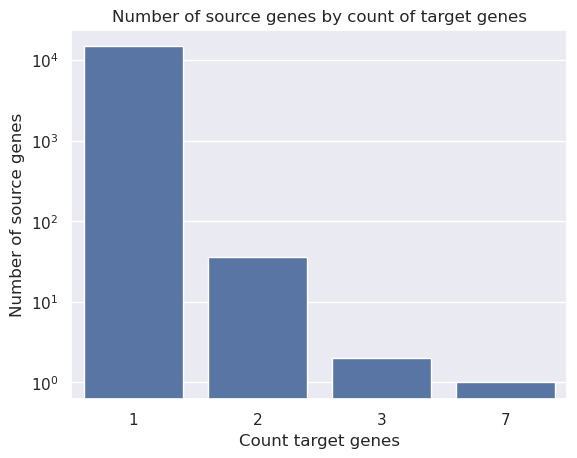

Filtered source DataFrame with target_counts <= 1:


,Marker,Info
0,PVALB8 ENSDARG00000037790,Mucous cell
1,PVALB8 ENSDARG00000037790,Filament ionocyte
2,PVALB8 ENSDARG00000037790,Müller glia
3,HBAA1 ENSDARG00000097011,Mucous cell
4,HBAA1 ENSDARG00000097011,Erythrocyte_cahz high
...,...,...
8636,ATP1B2B ENSDARG00000034424,Retinal cone cell
8637,GRK7A ENSDARG00000020602,Retinal cone cell
8638,PRPH2A ENSDARG00000038018,Retinal cone cell
8639,PPA1A ENSDARG00000099933,Retinal cone cell


Filtered: 8349 source genes, 49.14%

Create DataFrame containing the transferred genes based on the filter criteria.

The Marker Transfer Rate is 97.60%, indicating the percentage of successfully transferred markers from the source to the target organism.

Transferred markers:


,Marker,Info
0,OCM ENSG00000122543,Mucous cell
1,OCM ENSG00000122543,Filament ionocyte
2,OCM ENSG00000122543,Müller glia
3,HBZ ENSG00000130656,Mucous cell
4,HBZ ENSG00000130656,Erythrocyte_cahz high
...,...,...
8636,ATP1B2 ENSG00000129244,Retinal cone cell
8637,GRK7 ENSG00000114124,Retinal cone cell
8638,PRPH2 ENSG00000112619,Retinal cone cell
8639,PPA2 ENSG00000138777,Retinal cone cell


Weighted transferred markers:


,Marker,Info,Score
4111,PGLS ENSG00000130313,Innate immune cell,0.0
122,MAF1 ENSG00000179632,Fibroblast,0.0
125,IRAK1BP1 ENSG00000146243,Fibroblast,0.0
133,CCDC83 ENSG00000150676,Fibroblast,0.0
8580,CRYAB ENSG00000109846,Stromal cell,0.0
...,...,...,...
2859,CKB ENSG00000166165,Granulosa cell_cmah high,1.0
2860,CKB ENSG00000166165,Oocyte_ca15b high,1.0
2193,CKB ENSG00000166165,Oocyte,1.0
2195,CKB ENSG00000166165,Oocyte_h2af1al high,1.0


Marker list saved: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/transferred_markers/zebrafish_human_HomoloGene_remove_20240226163127

Starting BioMart approach...

Specify BioMart target organism selection:
Selection: hsapiens


Specify BioMart source organism selection:
Selection: drerio

Loading genes of zebrafish...
Done!

Fetch necessary data from BioMart...

DataFrame of the markers of the source organism (zebrafish) to be transferred to the target organism (human):


,Marker,Info
0,MUC5.2 ENSDARG00000058556,Mucous cell
1,HBBA1 ENSDARG00000097238,Mucous cell
2,PVALB8 ENSDARG00000037790,Mucous cell
3,SI:CH211-5K11.8 ENSDARG00000079078,Mucous cell
4,SI:CH211-125E6.11 ENSDARG00000025783,Mucous cell
...,...,...
21905,SAGA ENSDARG00000012610,Retinal cone cell
21906,PDE6A ENSDARG00000000380,Retinal cone cell
21907,MTBL ENSDARG00000102051,Retinal cone cell
21908,SI:CH73-281N10.2 ENSDARG00000097102,Retinal cone cell


Filter source DataFrame by the number of target genes per source gene: remove all source genes that lead to more than 1 target genes.

The Marker Transfer Rate is 94.40%, indicating the percentage of successfully transferred markers from the source to the target organism.

General information:
Percentage of genes that can potentially be transferred from the source organism: 65.22%
If all genes from the source organism were transferred, they would cover 34.82% of all genes of the target organism.

Count of target genes per source gene:


,Source Gene,Count target genes
3028,SI:CH211-170D8.8 ENSDARG00000090945,22
1956,SI:CH211-193E13.5 ENSDARG00000052656,22
2951,SI:DKEY-26C10.5 ENSDARG00000088023,22
1770,UGT5G2 ENSDARG00000043901,19
1214,UGT5G1 ENSDARG00000032862,19
...,...,...
1234,LRPAP1 ENSDARG00000033604,1
1235,RASGEF1BA ENSDARG00000033614,1
1236,STMN1B ENSDARG00000033655,1
1237,TPMA ENSDARG00000033683,1


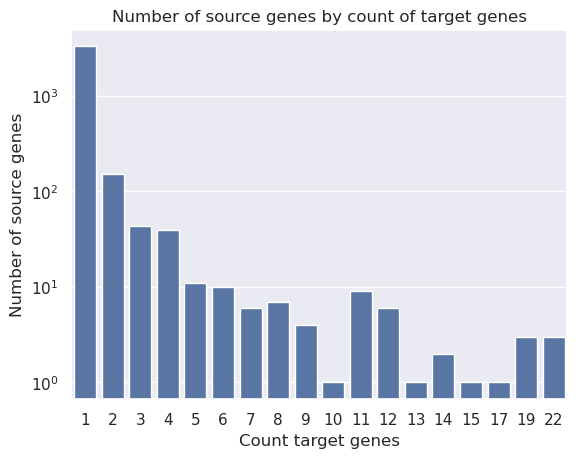

Filtered source DataFrame with target_counts <= 1:


,Marker,Info
0,MUC5.2 ENSDARG00000058556,Mucous cell
1,MUC5.2 ENSDARG00000058556,Epithelial cell
2,MUC5.2 ENSDARG00000058556,Vasculature
3,HBBA1 ENSDARG00000097238,Mucous cell
4,HBBA1 ENSDARG00000097238,Spermatid
...,...,...
10933,PRPH2A ENSDARG00000038018,Retinal cone cell
10934,PPA1A ENSDARG00000099933,Retinal cone cell
10935,SLC1A2A ENSDARG00000052138,Retinal cone cell
10936,SH3GL2A ENSDARG00000023600,Retinal cone cell


Filtered: 6052 source genes, 35.62%

Create DataFrame containing the transferred genes based on the filter criteria.

The Marker Transfer Rate is 100.00%, indicating the percentage of successfully transferred markers from the source to the target organism.

Transferred markers:


,Marker,Info
0,OSTC ENSG00000198856,Proliferating cell
1,TPPP3 ENSG00000159713,Macrophage
2,TPPP3 ENSG00000159713,Skeletal muscle cell
3,TPPP3 ENSG00000159713,Vasculature
4,SLC39A9 ENSG00000029364,Spermatid
...,...,...
10933,MT-CYB ENSG00000198727,Nephron epithelial cell
10934,MT-CYB ENSG00000198727,Proximal tubular cell
10935,MT-CYB ENSG00000198727,Endothelial cell (lymph)
10936,MT-CYB ENSG00000198727,Müller glia


Weighted transferred markers:


,Marker,Info,Score
1118,MATN1 ENSG00000162510,Stromal cell,0.0
1128,SPG21 ENSG00000090487,Macrophage_grn2 high,0.0
7472,ALOX5 ENSG00000012779,Monocyte,0.0
5797,COL9A2 ENSG00000049089,Müller glia,0.0
5784,NUCB2 ENSG00000070081,Macrophage,0.0
...,...,...,...
4682,CKB ENSG00000166165,NaK ionocyte,1.0
4683,CKB ENSG00000166165,Pharyngeal arch cell_ponzr3 high,1.0
4684,CKB ENSG00000166165,NCC ionocyte,1.0
4685,CKB ENSG00000166165,B cell,1.0


Marker list saved: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/transferred_markers/zebrafish_human_BioMart_remove_20240226163131

Finished!


In [23]:
# The main goal of this notebook is to identify homologous genetic markers in a target organism based
# on markers from a source organism using the BioMart or HomoloGene databases

# The source and target organisms are set with the value "None" at the beginning so that the user can choose from the list 
# of available organisms

# As explained above, this notebook was created specifically to translate zebrafish markers (source organims) 
# to human markers (target organisms)

# To expedite the search for marker lists, we utilize the name of the individual who uploaded the zebra markers 
# to the repository (Marta Quintanilla) 

# Continuing witht the filtering process, we select the file "zebra_complete", which contains the list of tissues uploaded 
# using the notebooks "mySubmit_Tissues.ipynb" and "mySubmit.ipynb"

# The output of the function is a new list containing the transferred markers 
# These markers undergo weighing before being utilized as input for the annotation tool
# Finally, the function provides the path where the new markers are located, obtained through both the BioMart and 
# HomoloGene approaches

marker_lists_homo = wrap.transfer_markers(target_org="human 9606", source_df=None, repo_path=repo_path, target_counts=1, 
                      weight_markers=True, export_suffix="remove")

## Annotate adata using the created list(s)

Merge the marker list with the original human markers and the transferred marker lists with the from zebrafish translated markers

In [24]:
merge_marker_lists = marker_lists + marker_lists_homo

Show new annotation column.

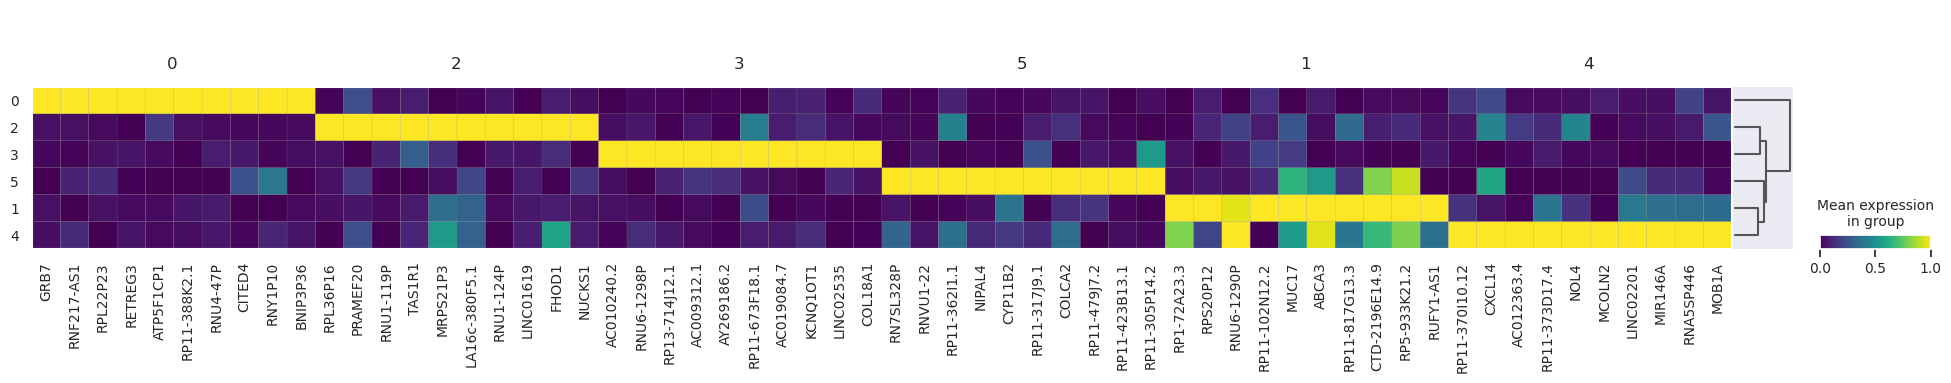

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


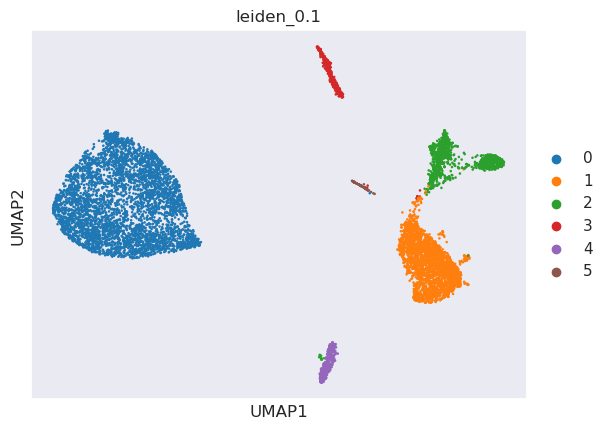

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


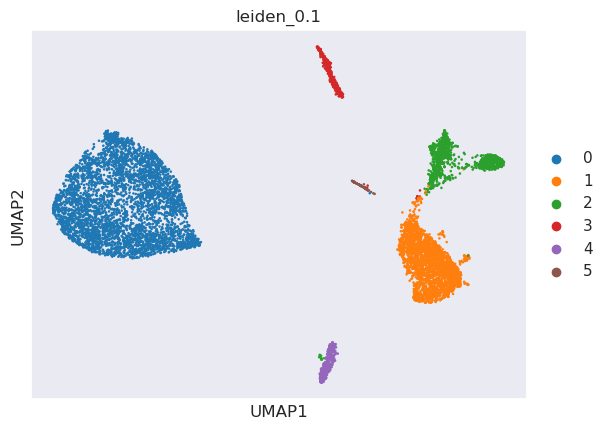

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


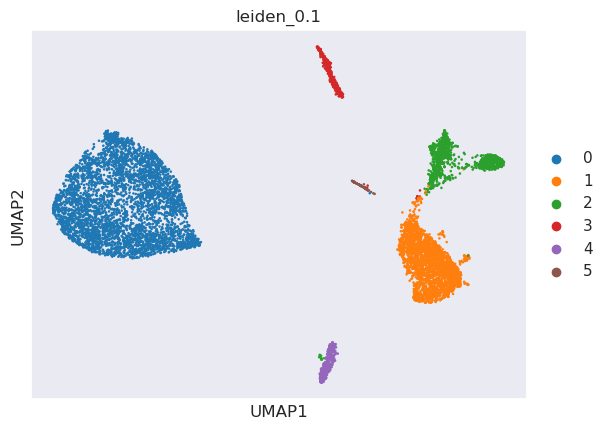

Comparison of cell type annotations:


,mr_two_column_20240226163059,mr_zebrafish_human_HomoloGene_remove_20240226163127,mr_zebrafish_human_BioMart_remove_20240226163131
leiden_0.1,,,
0,Neurons,Spermatogonia,Spermatid
1,Interneurons,Thrombocyte,Thrombocyte
2,Fibroblasts,Spermatid,Spermatid
3,Cajal-Retzius cells,Spermatid,Spermatid
4,Fibroblasts,Macrophage,Fibroblast
5,Macrophages,Macrophage,Thrombocyte


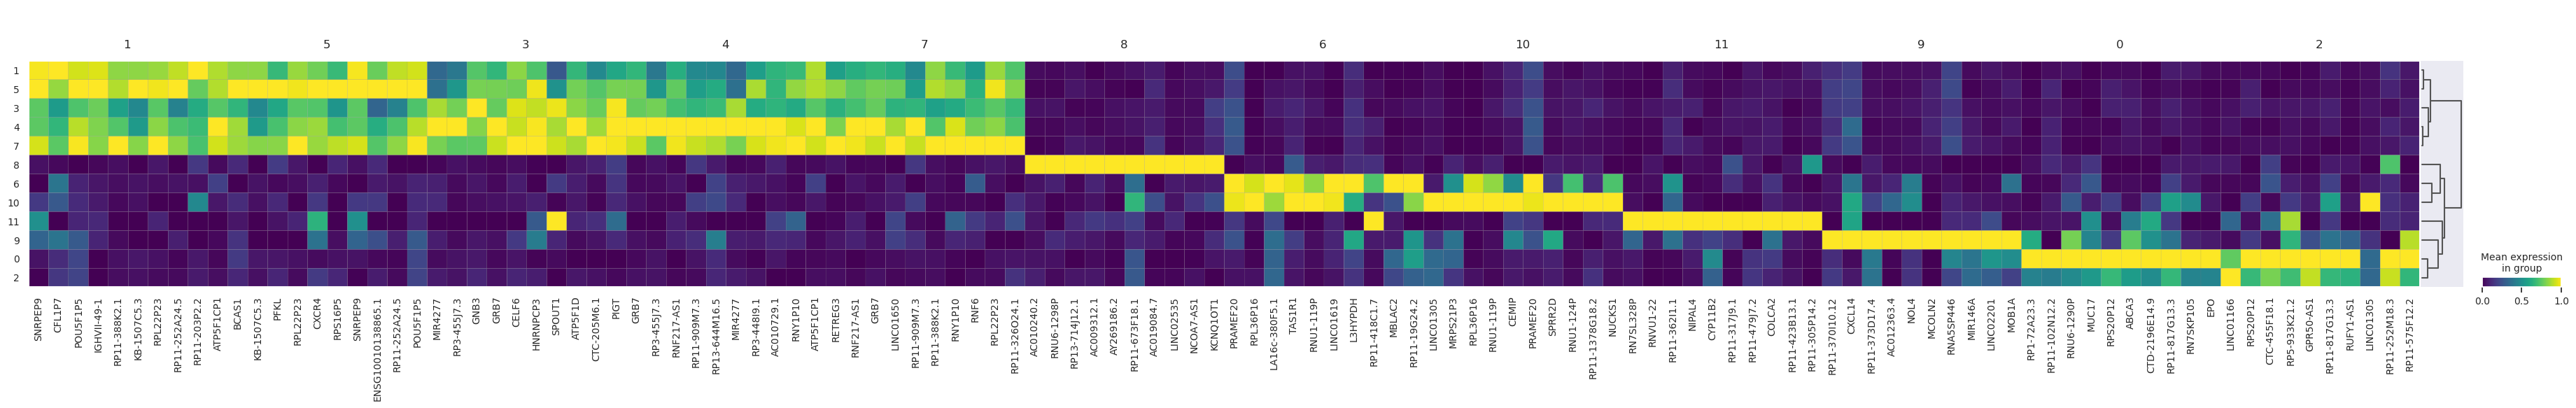

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


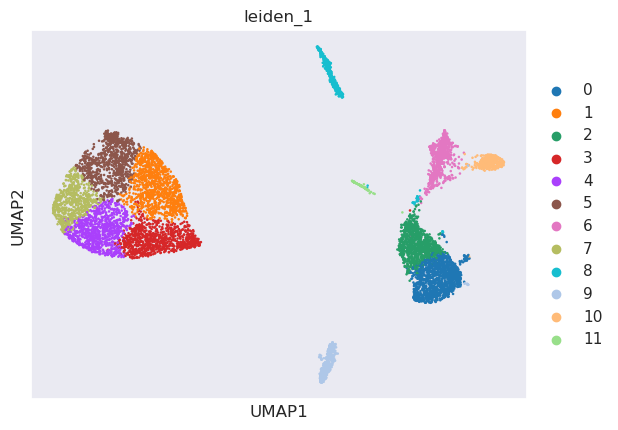

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


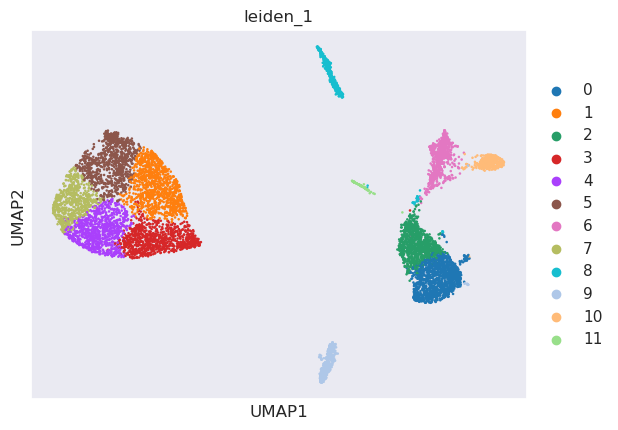

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


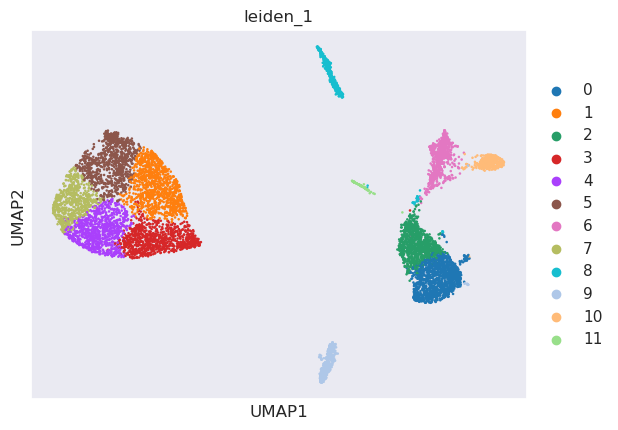

Comparison of cell type annotations:


,mr_two_column_20240226163059,mr_zebrafish_human_HomoloGene_remove_20240226163127,mr_zebrafish_human_BioMart_remove_20240226163131
leiden_1,,,
0,Interneurons,Spermatid,Thrombocyte
1,Endothelial cells,Fibroblast,Fibroblast
2,Platelets,Thrombocyte,Thrombocyte
3,Interneurons,Spermatid,Spermatid
4,Neurons,Proliferating cell,Spermatogonia
5,Enterocytes,Spermatid,Spermatid
6,Interneurons,Spermatid,Macrophage_grn2 high
7,Neurons,Spermatogonia,Spermatid
8,Cajal-Retzius cells,Spermatid,Spermatid


In [27]:
annotation_results = auto.multiple_annotation(adata, merge_marker_lists, clustering_column_list, rank_genes_column, celltype_column_name, True, h5ad_path)

Delete created marker lists.

In [33]:
if delete_lists:
    mr.delete_files(marker_lists)

File deleted: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/two_column_20240226163059
